In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import glob
import PIL
import matplotlib.pyplot as plt 
from scipy import stats
from PIL import Image
from scipy import optimize
from sklearn.metrics import r2_score
import pandas as pd
from matplotlib.patches import Rectangle
from pylab import gray, imshow, show
import cv2


In [3]:
image_list = glob.glob(r'/users/zoe/Desktop/IC/Data/Test_Image_Data/*.jpg')
from PIL import Image
def calculate_quality_score():
    for i in range (len(image_list)):
        quality=[]
        image = Image.open(image_list[i])
        image = image.convert('L')
        image_data = np.array(image)
        # image_data = np.where(image_data>0, 1, 0)
        # image_data = image_data.astype(np.uint8)
        # image_data = cv2.resize(image_data, (256, 256))
        # image_data = image_data
        # Thresholding for binary image
        background = np.mean(image_data)
        corrected_data = image_data - background
        threshold = 0.5

        binary_image = corrected_data > threshold
        
        # Calculate properties of the thresholded region
        properties = measure.regionprops(binary_image.astype(int))
        
        # If there's no valid region, return a score of 0
        if not properties:
            return 0
        
        prop = properties[0]
        
        # Circularity Score
        circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
        
        # Intensity Uniformity Score
        mask = binary_image.astype(bool)
        intensities_within_spot = corrected_data[mask]
        max_possible_std_dev = 0.5 * corrected_data.max()  # A simplistic assumption for max possible standard deviation
        uniformity = 1 - (np.std(intensities_within_spot) / max_possible_std_dev)
        
        # Overall Quality Score
        overall_quality = (circularity + uniformity) / 2
        quality.append(overall_quality)
        score=np.mean(quality)
    return score

calculate_quality_score()



0.4155050677264128

In [23]:
#import our image file
def calculate_quality_score2(image_data):
    # Thresholding for binary image
    threshold = 0.5
    binary_image = image_data > threshold
    
    # Calculate properties of the thresholded region
    properties = measure.regionprops(binary_image.astype(int))
    
    # If there's no valid region, return a score of 0
    if not properties:
        return 0
    
    prop = properties[0]
    
    # Circularity Score
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
    
    # Intensity Uniformity Score
    mask = binary_image.astype(bool)
    intensities_within_spot = image_data[mask]
    max_possible_std_dev = 0.5 * image_data.max()  # A simplistic assumption for max possible standard deviation
    uniformity = 1 - (np.std(intensities_within_spot) / max_possible_std_dev)
    
    # Overall Quality Score
    overall_quality = (circularity + uniformity) / 2
    return overall_quality




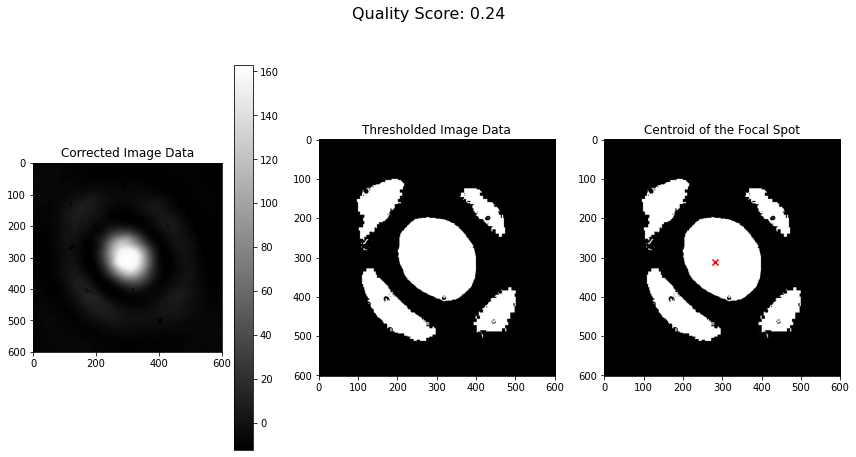

In [72]:
# Background subtraction
image = Image.open(image_list[6])
image = image.convert('L')
image_data = np.array(image)
background = np.mean(image_data)
corrected_data = image_data - background

# Calculate quality score
quality_score = calculate_quality_score2(corrected_data)

# Visualization
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(corrected_data, cmap='gray')
plt.title('Corrected Image Data')
plt.colorbar()

# Thresholded image
threshold = 0.5
binary_image = corrected_data > threshold
plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Thresholded Image Data')

# Showing centroid
properties = measure.regionprops(binary_image.astype(int))
if properties:
    centroid = properties[0].centroid
    plt.subplot(1, 3, 3)
    plt.imshow(binary_image, cmap='gray')
    plt.scatter(centroid[1], centroid[0], color='r', marker='x')
    plt.title('Centroid of the Focal Spot')

# Print quality score
plt.suptitle(f'Quality Score: {quality_score:.2f}', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [42]:
image = Image.open(image_list[9])
image = image.convert('L')
image_data = np.array(image)

from skimage.filters import sobel

def focal_spot_quality_v2(image_data):
    # Normalize the image
    norm_image = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    
    # Compute the gradient magnitude (edge sharpness)
    edges = sobel(norm_image)
    edge_score = 1 / (1 + np.mean(edges))
    
    # Intensity spread
    intensity_hist, _ = np.histogram(norm_image, bins=256)
    peak_height = np.max(intensity_hist)
    spread = np.sum(intensity_hist * (1 - intensity_hist / peak_height))
    spread_score = 1 / (1 + spread / (norm_image.size))
    
    # Peak-to-noise ratio
    peak_intensity = np.max(norm_image)
    noise_level = np.percentile(norm_image, 5)  # A rough estimate, considering the 5th percentile as noise
    pnr_score = peak_intensity / (noise_level + 1e-6)
    pnr_score = 1 if pnr_score > 1 else pnr_score  # Clip at 1
    
    # Combine scores
    overall_score = (edge_score + spread_score + pnr_score) / 3
    
    return overall_score

# Use this function on your data
quality = focal_spot_quality_v2(image_data)
print(quality)



0.9022695503713988


In [76]:
import numpy.fft as fft
image = Image.open(image_list[6])
image = image.convert('L')
image_data = np.array(image)

def fourier_quality(image_data):
    # Compute the 2D Fourier Transform
    f_transform = fft.fft2(image_data)
    f_transform_shifted = fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_transform_shifted)
    
    # Define a region around the center (low-frequency)
    center_radius = 3.5 # You might need to adjust this based on your image resolution and content
    total_energy = np.sum(magnitude_spectrum**2)
    
    y, x = np.ogrid[-image_data.shape[0]//2:image_data.shape[0]//2, -image_data.shape[1]//2:image_data.shape[1]//2]
    mask = x*x + y*y <= center_radius*center_radius
    low_freq_energy = np.sum(magnitude_spectrum[mask]**2)
    
    # The score is the ratio of low-frequency energy to the total energy. 
    # We clip it to [0,1] to ensure bounds.
    score = np.clip(low_freq_energy / total_energy, 0, 1)

    return score

quality = fourier_quality(image_data)
print(quality)



0.8072867028893427


In [19]:
import laserbeamsize as lbs

image = Image.open(image_list[9])
image = image.convert('L')
image_data = np.array(image)
squeezed_image_array = image_data
score = []

QUALITY_MIN = 0  # Placeholder for the worst quality you've observed
QUALITY_MAX = 10  # Placeholder for the best quality you've observed


x, y, dx, dy, phi = lbs.beam_size(squeezed_image_array)
denominator = max(dx, dy)
if denominator == 0:
    denominator = denominator + 0.000001

Ellipticity = min(dx, dy) / denominator
threshold_up_area = (squeezed_image_array >= np.max(squeezed_image_array) / 10) + 0  # define a threshold area
total_pixel = squeezed_image_array.shape[0] * squeezed_image_array.shape[1]
dispersion = total_pixel / np.sum(threshold_up_area)
quality_number = dispersion * Ellipticity

# Normalize the quality number to the [0, 1] range
normalized_quality = (quality_number - QUALITY_MIN) / (QUALITY_MAX - QUALITY_MIN)
normalized_quality = np.clip(normalized_quality, 0, 1)  # Ensures the value remains within [0,1]

score.append(normalized_quality)

average_score = np.mean(score)
print(average_score)



0.3659894988820055


In [ ]:
def get_quality_number2():
    # Take image and calculate the quality number
    raw_image_array = cam.grab(10)  # grab 10 frames
    image_array = np.array(raw_image_array)
    squeezed_image_array = image_array.squeeze()
    score = []

    QUALITY_MIN = 0  # Placeholder for the worst quality you've observed
    QUALITY_MAX = 10  # Placeholder for the best quality you've observed

    for i in range(len(squeezed_image_array)):
        x, y, dx, dy, phi = lbs.beam_size(squeezed_image_array[i])
        denominator = max(dx, dy)
        if denominator == 0:
            denominator = denominator + 0.000001

        Ellipticity = min(dx, dy) / denominator
        threshold_up_area = (squeezed_image_array[i] >= np.max(squeezed_image_array[i]) / 10) + 0  # define a threshold area
        total_pixel = squeezed_image_array[i].shape[0] * squeezed_image_array[i].shape[1]
        dispersion = total_pixel / np.sum(threshold_up_area)
        quality_number = dispersion * Ellipticity

        # Normalize the quality number to the [0, 1] range
        normalized_quality = (quality_number - QUALITY_MIN) / (QUALITY_MAX - QUALITY_MIN)
        normalized_quality = np.clip(normalized_quality, 0, 1)  # Ensures the value remains within [0,1]

        score.append(normalized_quality)
    
    average_score = np.mean(score)
    return average_score

s2 = get_quality_number2()
print(s2)
